In [24]:
from PIL import Image, ImageFilter
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import ceil, floor
from numpy import argmax, mean, round, sum
import os

In [25]:
def showw(path, yea=True):
    if yea:plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

def G_N(input_path, r):
    final_path = 'jet_fundus.jpg'
    image = Image.open(input_path) 
    image = image.filter(ImageFilter.GaussianBlur(r)) 
    image.save(final_path)
    return final_path

def D_E(n, it):
    input_path = 'jet_fundus.jpg'
    final_path = 'processed_jet_fundus1.jpg'

    image = Image.open(input_path).convert('RGB')

    image_np = np.array(image)

    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    kernel = np.ones((n, n), np.uint8)

    dilated_image = cv2.dilate(image_bgr, kernel, iterations=it)

    eroded_image = cv2.erode(dilated_image, kernel, iterations=it)

    result_image_rgb = cv2.cvtColor(eroded_image, cv2.COLOR_BGR2RGB)

    result_image_pil = Image.fromarray(result_image_rgb)

    result_image_pil.save(final_path)
    return final_path

def CLE(cl, n):
    input_path = 'processed_jet_fundus1.jpg'
    final_path = 'clahe_processed_jet_fundus1.jpg'

    image = cv2.imread(input_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    obj = cv2.createCLAHE(clipLimit=cl, tileGridSize=(n, n))
    v = obj.apply(v)
    hsv_image = cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)
    cv2.imwrite(final_path,hsv_image)
    return final_path

def SBL(th):
    input_path = 'processed_jet_fundus1.jpg'
    final_path = 'edge_processed_jet_fundus.jpg'
    
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    temp = np.zeros_like(grad)
    temp[np.where(grad >= th)] = 1
    temp[np.where(grad < th)] = 0
    # plt.imshow(temp, cmap='gray')
    temp[np.where(temp >= 1)] = 255
    cv2.imwrite(final_path, temp)
    return final_path

def CIR(temp_path, mn, mx, fin_CLDE_path, fin_org_path, perturb, mask_path, fin_mask_path):
    input_path = 'edge_processed_jet_fundus.jpg'
    color_path = 'clahe_processed_jet_fundus1.jpg'

    gray_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(cv2.imread(color_path), cv2.COLOR_BGR2RGB)
    temp_img = cv2.cvtColor(cv2.imread(temp_path), cv2.COLOR_BGR2RGB)

    mask_img = cv2.imread(mask_path)

    circles = cv2.HoughCircles(
        gray_img, 
        cv2.HOUGH_GRADIENT, dp=1, minDist=100,
        param1=50, param2=30, minRadius=mn, maxRadius=mx
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        
        x, y, r = circles[0]
        
        rmn, rmx, cmn, cmx = y - perturb, y + perturb, x - perturb, x + perturb

        cv2.imwrite(fin_CLDE_path, cv2.cvtColor(image[rmn:rmx, cmn:cmx], cv2.COLOR_BGR2RGB))
        cv2.imwrite(fin_org_path, cv2.cvtColor(temp_img[rmn:rmx, cmn:cmx], cv2.COLOR_BGR2RGB))
        cv2.imwrite(fin_mask_path, mask_img[rmn:rmx, cmn:cmx])

    else:
        print(f"No circles were detected in {temp_path}\n")

In [41]:
def Gaussian_Blur_or_Noise(input_path, final_path, r):
    image = Image.open(input_path) 
    image = image.filter(ImageFilter.GaussianBlur(r)) 
    image.save(final_path)
    plt.imshow(image)

def dilation_erosion(image_path, final_path, n, it):
    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    kernel = np.ones((n, n), np.uint8)

    dilated_image = cv2.dilate(image_bgr, kernel, iterations=it)

    eroded_image = cv2.erode(dilated_image, kernel, iterations=it)

    result_image_rgb = cv2.cvtColor(eroded_image, cv2.COLOR_BGR2RGB)

    result_image_pil = Image.fromarray(result_image_rgb)

    plt.imshow(result_image_pil)

    result_image_pil.save(final_path)

def clahe(input_path, final_path, cl, n):
    image = cv2.imread(input_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    obj = cv2.createCLAHE(clipLimit=cl, tileGridSize=(n, n))
    v = obj.apply(v)
    hsv_image = cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)
    plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite(final_path,hsv_image)

def getBins(blk):
    r, c = blk.shape
    r = 2 * floor(r / 2)
    c = 2 * floor(c / 2)
    blk = cv2.resize(blk, (c, r))
    v = np.array([[1, -1], [1, -1]])
    h = np.array([[1, 1], [-1, -1]])
    d45 = np.array([[1.414, 0], [0, -1.414]]) 
    d135 = np.array([[0, 1.414], [-1.414, 0]])
    iso = np.array([[2, -2], [-2, 2]])

    th = 50
    l = 0

    bins = [0]*5
    for _ in range(c//2):
        k = 0
        for _ in range(r//2):
            block = blk[k : k + 2, l : l + 2]
            pv = abs(sum(block*v))
            ph = abs(sum(block*h))
            pd45 = abs(sum(block*d45))
            pd135 = abs(sum(block*d135))
            piso = abs(sum(block*iso))
            temp = [max([pv, ph, pd45, pd135, piso]), argmax([pv, ph, pd45, pd135, piso])]
            if temp[0] > th:    
                bins[temp[1]] += 1  
            k += 2 
        l += 2
    return bins 

def ehd(input_path):
    image = cv2.imread(input_path)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    r, c = gray_img.shape

    r = 4 * ceil(r / 4)
    c = 4 * ceil(c / 4)

    gray_img = cv2.resize(gray_img,dsize=(c, r))

    Allbins = []

    for i in range(4):
        for j in range(4):
            block = gray_img[i*r//4:(i+1)*r//4, j*c//4:(j+1)*c//4]
            Allbins.append(getBins(block))
            
    Allbins = np.array(Allbins)
    glob_hist = [round(mean(Allbins[:,i])) for i in range(5)]

    plt.bar(x=['v', 'h', 'd45', 'd135', 'iso'],height=glob_hist)

def sobel(input_path, th):
    image = cv2.imread(input_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    temp = np.zeros_like(grad)
    temp[np.where(grad >= th)] = 1
    temp[np.where(grad < th)] = 0
    plt.imshow(temp, cmap='gray')
    temp[np.where(temp >= 1)] = 255
    cv2.imwrite('edge_processed_jet_fundus.jpg', temp)

def watershed(image_path):

    img = cv2.imread(image_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    _, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((3, 3), np.uint8)
    imgDil = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    distTrans = cv2.distanceTransform(imgDil, cv2.DIST_L2, 5)

    _, distThresh = cv2.threshold(distTrans, 15, 128, cv2.THRESH_BINARY)

    distThresh = np.uint8(distThresh)

    _, labels = cv2.connectedComponents(distThresh)
    crd = np.where(labels==0)
    temp = np.zeros_like(img)

    labels = np.int32(labels)
    labels = cv2.watershed(img, labels)
    temp[crd] = img[crd]
    plt.imshow(labels)

def detect_circ(input_path, color_path, temp_path, temp1_path, mn, mx, perturb):
    gray_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(cv2.imread(color_path), cv2.COLOR_BGR2RGB)
    temp_img = cv2.cvtColor(cv2.imread(temp_path), cv2.COLOR_BGR2RGB)
    temp1_img = cv2.imread(temp1_path, cv2.IMREAD_GRAYSCALE)
    circles = cv2.HoughCircles(
        gray_img, 
        cv2.HOUGH_GRADIENT, dp=1, minDist=100,
        param1=50, param2=30, minRadius=mn, maxRadius=mx
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        
        x, y, r = circles[0]
        print(x, y, r)
        
        mask = np.zeros_like(gray_img)
        
        cv2.circle(mask, (x, y), r, 255, thickness=-1)
        result = cv2.bitwise_and(gray_img, gray_img, mask=mask)
        
        output = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(output)
        plt.title('Detected Circle on Fundus Image')
        
        plt.subplot(1, 2, 2)
        plt.imshow(result, cmap='gray')
        plt.title('Optic Disc Pixels')
        plt.show()

        
        rmn, rmx, cmn, cmx = y - perturb, y + perturb, x - perturb, x + perturb

        segm_sqr = image[rmn:rmx, cmn:cmx]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image[rmn:rmx, cmn:cmx])
        plt.title('clahe + DE')

        plt.subplot(1, 2, 2)
        plt.imshow(temp_img[rmn:rmx, cmn:cmx])
        plt.title('Orgn')
        cv2.imwrite('jet_clh.jpg', cv2.cvtColor(image[rmn:rmx, cmn:cmx], cv2.COLOR_BGR2RGB))
        cv2.imwrite('jet_org.jpg', cv2.cvtColor(temp_img[rmn:rmx, cmn:cmx], cv2.COLOR_BGR2RGB))

        # plt.subplot(1, 3, 3)
        # plt.imshow(temp1_img[rmn:rmx, cmn:cmx])
        # plt.title('clahe on Orgn')
        cv2.imwrite('mask_eye.jpg', temp1_img[rmn:rmx, cmn:cmx])
        
    else:
        print("No circles were detected")


In [27]:
lt = os.listdir(r"C:\Users\Krish\Downloads\newds\Drishti\Training-20211018T055246Z-001\Training\Images\NORMAL")

# 🌟 Gaussian Blur

In [267]:
# rt = np.random.randint(0, len(lt) - 1)
path = r"C:\Users\Krish\Downloads\jet\Ds\origa\images\638.jpg"

In [29]:
G_N(path, 2)

'jet_fundus.jpg'

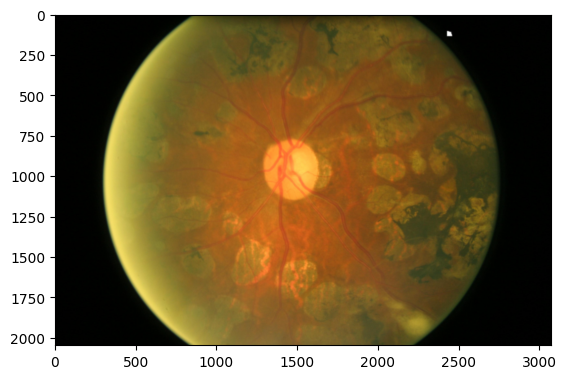

In [268]:
Gaussian_Blur_or_Noise(path, 'jet_fundus.jpg',2)

# 🌟 Dilation + Erosion

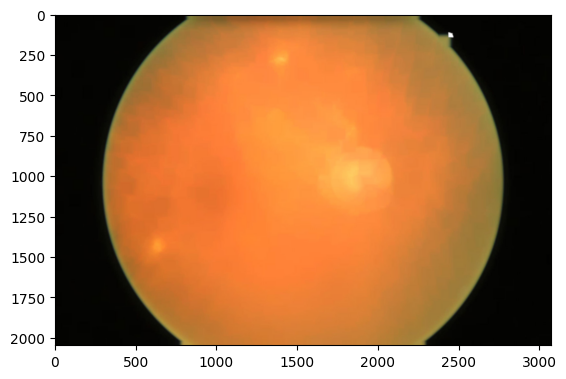

In [31]:
showw(D_E(8, 8))

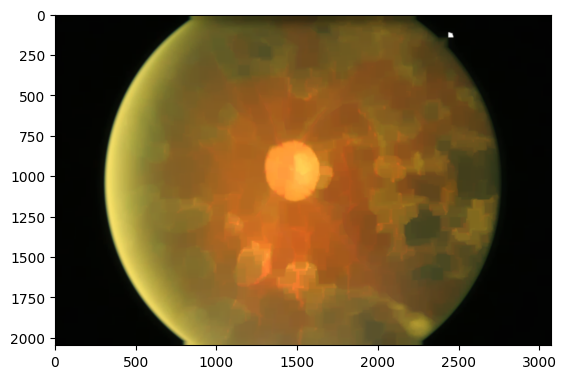

In [269]:
dilation_erosion('jet_fundus.jpg', 'processed_jet_fundus1.jpg', 8, 8)

# 🌟 Clahe on GaussBlur

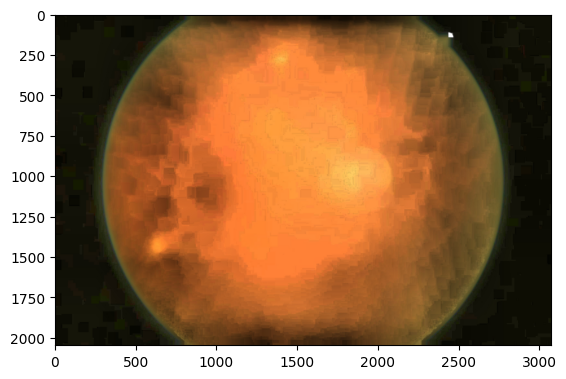

In [33]:
showw(CLE(8, 6))

In [ ]:
clahe('jet_fundus.jpg', 'clahe_processed_jet_fundus2.jpg',8,6)

# 🌟 Clahe on Dilatn + Eros

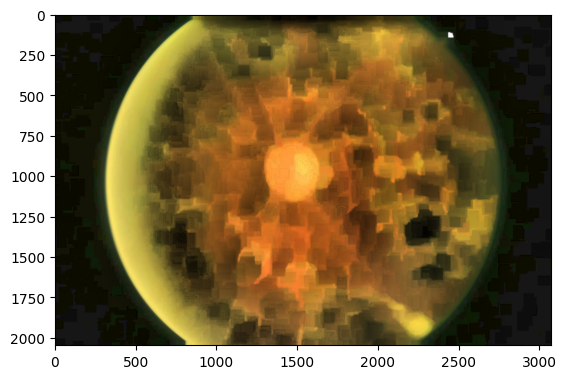

In [270]:
clahe('processed_jet_fundus1.jpg', 'clahe_processed_jet_fundus1.jpg',8,6)

# 🌟 Sobel

'edge_processed_jet_fundus.jpg'

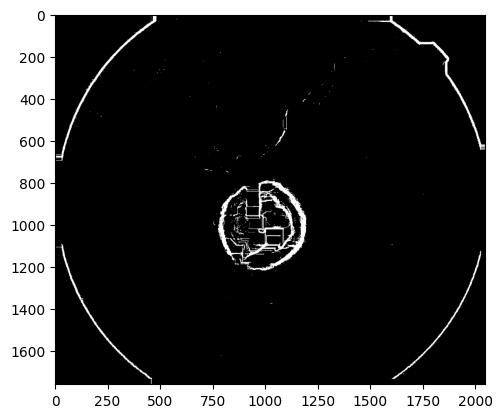

In [ ]:
SBL(85)

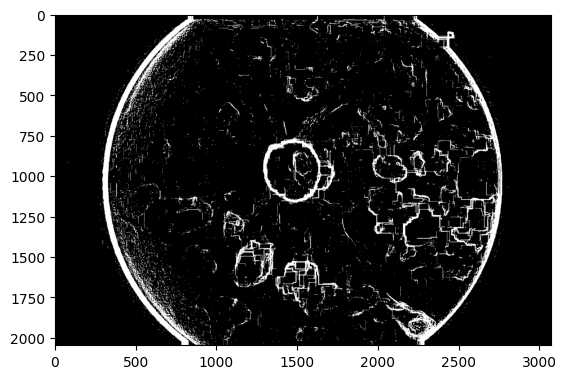

In [271]:
sobel('processed_jet_fundus1.jpg', 60)

# 🌟Detect Circle

In [ ]:
CIR(path, 50, 500, 'jet1.jpg', 'jet2.jpg', perturb=256)

1504 952 219


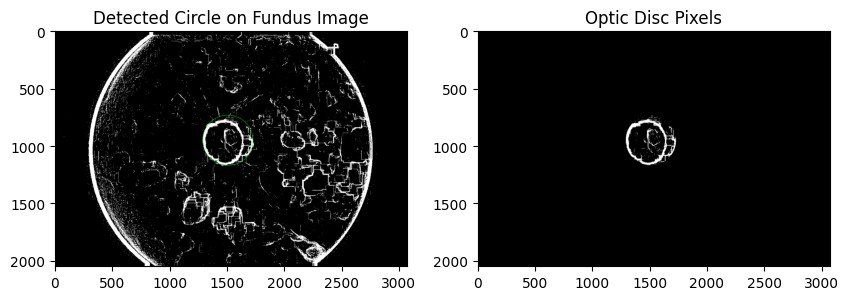

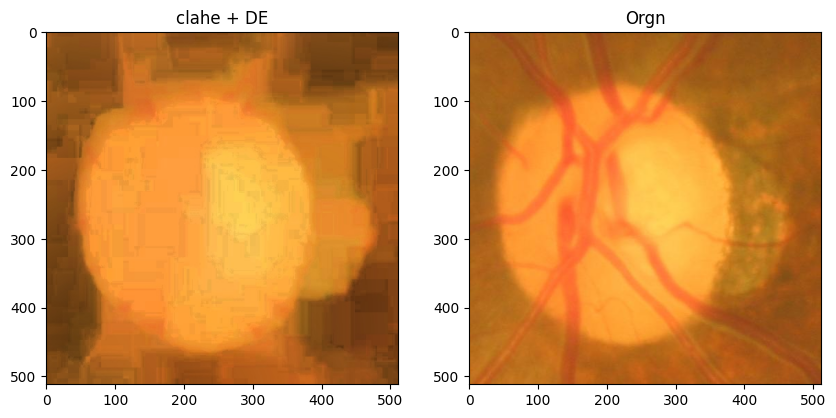

In [272]:
detect_circ('edge_processed_jet_fundus.jpg','clahe_processed_jet_fundus1.jpg', path, r"C:\Users\Krish\Downloads\jet\Ds\origa\mask\638.jpg", 50, 256, perturb=256)

In [113]:
path = r"C:\Users\Krish\Downloads\jet\Ds\origa\images"
mask_path = r"C:\Users\Krish\Downloads\jet\Ds\origa\mask" + chr(92)
fin_mask_path = r"C:\Users\Krish\Downloads\jet\Ds\origa\sgmask" + chr(92)
org_path = r"C:\Users\Krish\Downloads\jet\Ds\origa\org" + chr(92)
clhe_path = r"C:\Users\Krish\Downloads\jet\Ds\origa\clahe_DE" + chr(92)
tp = path + chr(92)

In [ ]:
"C:\Users\Krish\Downloads\jet\Ds\Train\mask"
"C:\Users\Krish\Downloads\newds\Drishti\Training-20211018T055246Z-001\Training\GT\drishtiGS_002\SoftMap\drishtiGS_002_ODsegSoftmap.png"

In [120]:
lis = os.listdir(path)
lis[300]

'301.jpg'

In [122]:
#85 -th, 50,500
for i in lis[301:]:
    print(i)
    G_N(path + chr(92) + i, 2)
    D_E(8, 8)
    CLE(8, 6)
    SBL(70)
    CIR(path + chr(92) + i, 50, 300, clhe_path + i, org_path + i, 256, mask_path + i, fin_mask_path + i)

302.jpg
303.jpg
304.jpg
305.jpg
306.jpg
307.jpg
308.jpg
309.jpg
310.jpg
311.jpg
312.jpg
313.jpg
314.jpg
315.jpg
316.jpg
317.jpg
318.jpg
319.jpg
320.jpg
321.jpg
322.jpg
323.jpg
324.jpg
325.jpg
326.jpg
327.jpg
328.jpg
329.jpg
330.jpg
331.jpg
332.jpg
333.jpg
334.jpg
335.jpg
336.jpg
337.jpg
338.jpg
339.jpg
340.jpg
341.jpg
342.jpg
343.jpg
344.jpg
345.jpg
346.jpg
347.jpg
348.jpg
349.jpg
350.jpg
351.jpg
352.jpg
353.jpg
354.jpg
355.jpg
356.jpg
357.jpg
358.jpg
359.jpg
360.jpg
361.jpg
362.jpg
363.jpg
364.jpg
365.jpg
366.jpg
367.jpg
368.jpg
369.jpg
370.jpg
371.jpg
372.jpg
373.jpg
374.jpg
375.jpg
376.jpg
377.jpg
378.jpg
379.jpg
380.jpg
381.jpg
382.jpg
383.jpg
384.jpg
385.jpg
386.jpg
387.jpg
388.jpg
389.jpg
390.jpg
391.jpg
392.jpg
393.jpg
394.jpg
395.jpg
396.jpg
397.jpg
398.jpg
399.jpg
400.jpg
401.jpg
402.jpg
403.jpg
404.jpg
405.jpg
406.jpg
407.jpg
408.jpg
409.jpg
410.jpg
411.jpg
412.jpg
413.jpg
414.jpg
415.jpg
416.jpg
417.jpg
418.jpg
419.jpg
420.jpg
421.jpg
422.jpg
423.jpg
424.jpg
425.jpg
426.jpg


# ///

In [3]:
import scipy.io
pth = r"D:\mine\sai\archive\ORIGA\ORIGA\Semi-automatic-annotations"
fin = r"C:\Users\Krish\Downloads\jet\Ds\origa\mask" + chr(92)
for i in os.listdir(pth):
    if '.tif' not in i:
        mat_file_path = pth + chr(92) + i
        mat = scipy.io.loadmat(mat_file_path)
        mat['mask'][np.where(mat['mask'] >= 1)] = 255
        plt.imshow(mat['mask'])
        cv2.imwrite(fin + i[:-4] + '.jpg', mat['mask'])

In [12]:
pth = r"C:\Users\Krish\Downloads\jet\Ds\Train\mask"
fin = r"C:\Users\Krish\Downloads\jet\Ds\Train\Bin_mask"
for i in os.listdir(pth):
    a = cv2.imread(pth + chr(92) + i)
    a[np.where(a >= 128)] = 255
    a[np.where(a < 128)] = 0
    cv2.imwrite(fin + chr(92) + i, a)

In [34]:
a = cv2.imread(r"C:\Users\Krish\OneDrive - Amrita Vishwa Vidyapeetham\Krish_PYT\mask_eye.jpg")
a[np.where(a >= 150)] = 255
a[np.where(a < 150)] = 0
cv2.imwrite(r"C:\Users\Krish\OneDrive - Amrita Vishwa Vidyapeetham\Krish_PYT\drishtiGS_096.jpg", a)

True

In [28]:
def omg(temp_path, mn, mx, perturb):

    gray_img = cv2.imread(temp_path, cv2.IMREAD_GRAYSCALE)

    circles = cv2.HoughCircles(
        gray_img, 
        cv2.HOUGH_GRADIENT, dp=1, minDist=100,
        param1=50, param2=30, minRadius=mn, maxRadius=mx
    )

    if circles is  None:
        return
        # circles = np.round(circles[0, :]).astype("int")
        
        # x, y, r = circles[0]
        
        # rmn, rmx, cmn, cmx = y - perturb, y + perturb, x - perturb, x + perturb

    else:
        # print(f"No circles were detected in {temp_path}\n")
        return temp_path

In [117]:
cnt = 0
cnt1 = 0
lt = []
for i in os.listdir(r'C:\Users\Krish\Downloads\jet\Ds\origa\sgmask'):
    if not cv2.imread(r'C:\Users\Krish\Downloads\jet\Ds\origa\sgmask' + chr(92) + i).any():
        cnt1 += 1
        lt.append(i)
    cnt += 1

100 - (cnt1/cnt) * 100, cnt1, cnt

(97.37654320987654, 17, 648)

In [186]:
lt[7:]

['315.jpg',
 '316.jpg',
 '349.jpg',
 '434.jpg',
 '469.jpg',
 '487.jpg',
 '491.jpg',
 '575.jpg',
 '589.jpg',
 '638.jpg']

In [36]:
from albumentations import HorizontalFlip, CoarseDropout, RandomBrightness, RandomContrast, RandomBrightnessContrast
import cv2
import matplotlib.pyplot as plt

In [31]:
tp = r"\469.jpg"
x = cv2.cvtColor(cv2.imread(r"C:\Users\Krish\Downloads\jet\Ds\Temp\origa\org" + tp), cv2.COLOR_BGR2RGB)
y = cv2.imread(r"C:\Users\Krish\Downloads\jet\Ds\Temp\origa\sgmask" + tp,cv2.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'aug')

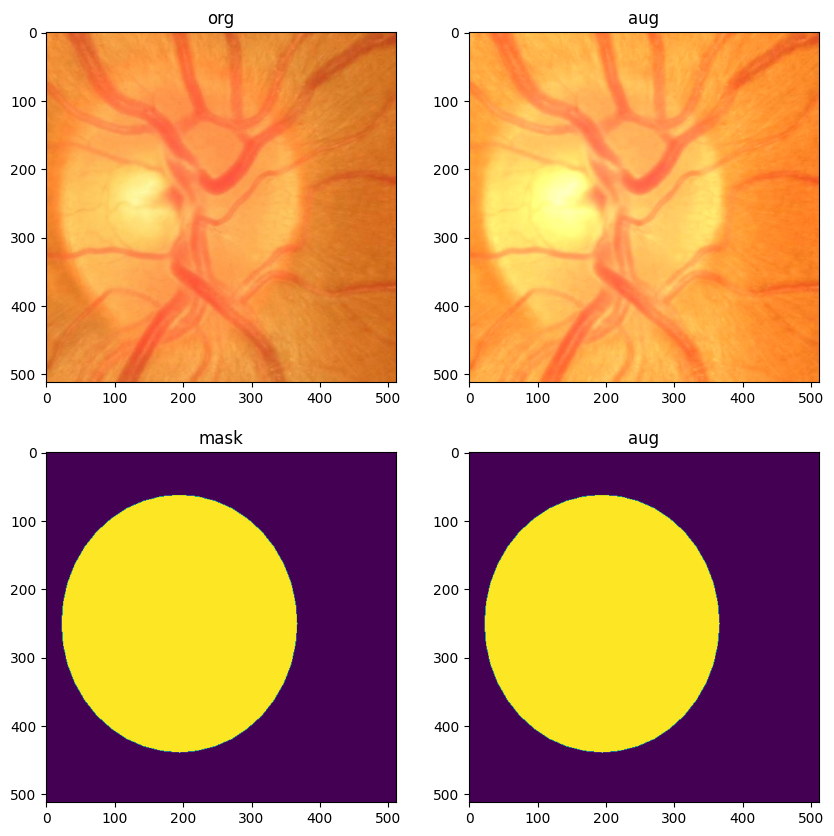

In [63]:
aug = RandomContrast(p=1)
ag = aug(image = x, mask = y)
x1 = ag['image']
y1 = ag['mask']
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(x)
plt.title('org')

plt.subplot(2, 2, 2)
plt.imshow(x1)
plt.title('aug')

plt.subplot(2, 2, 3)
plt.imshow(y)
plt.title('mask')

plt.subplot(2, 2, 4)
plt.imshow(y1)
plt.title('aug')

In [78]:
import os
def save_Dataset(resize, image_path, mask_path, augment = False):
    for x in sorted(os.listdir(image_path)):
        name = x
        x = cv2.imread(image_path + chr(92) + x)
        y = cv2.imread(mask_path + chr(92) + name)
        x = cv2.resize(x,dsize=(resize, resize))
        y = cv2.resize(y,dsize=(resize, resize))
        pth = r"C:\Users\Krish\Downloads\jet\Ds\augm\segm_test\img"
        pth1 = r"C:\Users\Krish\Downloads\jet\Ds\augm\segm_test\mask"
        aug_x = [x]
        aug_y = [y]
        if augment:
            aug = HorizontalFlip(p=1)
            ag = aug(image = x, mask = y)
            x1 = ag['image']
            y1 = ag['mask']
            aug_x.append(x1)
            aug_y.append(y1)

            for i in range(2):
                aug = RandomBrightnessContrast(p=1)
                ag = aug(image = x)
                x3 = ag['image']
                aug_x.append(x3)
                aug_y.append(y)


                # aug = RandomContrast(p=1)
                # ag = aug(image = x)
                # x4 = ag['image']
                # aug_x.append(x4)
                # aug_y.append(y)


                # aug = CoarseDropout(p=i, max_holes=10, max_height=13, max_width=13)
                # ag = aug(image = x, mask = y)
                # x2 = ag['image']
                # y2 = ag['mask']
                # aug_x.append(x2)
                # aug_y.append(y2)

        idx = 0
        for ax, ay in zip(aug_x, aug_y):
            cv2.imwrite(pth + chr(92) + str(idx) + '_' + name,ax) #imgs
            cv2.imwrite(pth1 + chr(92) + str(idx) + '_' + name,ay) #label
            idx += 1

In [79]:
save_Dataset(resize = 128,image_path=r"C:\Users\Krish\Downloads\jet\Ds\Segm\seg_test\img", mask_path=r"C:\Users\Krish\Downloads\jet\Ds\Segm\seg_test\mask", augment=True)